# Q2: "AI 세율의 최적 수준은 어떻게 설정할 수 있는가?"에 대한 분석 방법

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, differential_evolution
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [23]:
file_path = "../data/master_data_by_category_clear.csv"
df = pd.read_csv(file_path)

df_numeric = df.select_dtypes(include=[np.number])

# GDP와 상관관계 높은 변수 자동 선정 (GDP 제외)
correlation_threshold = 0.45
correlations = df_numeric.corr()["GDP"].drop("GDP").abs()
selected_features = correlations[correlations > correlation_threshold].index.tolist()

In [24]:
print(f"GDP와 높은 상관관계를 가진 변수들: {selected_features}")

GDP와 높은 상관관계를 가진 변수들: ['Business sophistication', 'General Revenue', 'Knowledge and technology outputs', 'Patent Publications', 'WIPO Tax']


### AI Tax Proxy 후보 조합 생성

In [25]:
proxy_candidates = []
scaler = StandardScaler()

for r in range(2, 4):
    for combo in combinations(selected_features, r):
        valid_combo = [col for col in combo if col in df.columns]
        if len(valid_combo) == r:
            proxy_name = f"AI_Tax_Proxy_{'_'.join(valid_combo)}"
            df_scaled = scaler.fit_transform(df[valid_combo])
            df[proxy_name] = df_scaled.mean(axis=1)
            proxy_candidates.append(proxy_name)

print(f"생성된 AI 세율 Proxy 후보들: {proxy_candidates}")

생성된 AI 세율 Proxy 후보들: ['AI_Tax_Proxy_Business sophistication_General Revenue', 'AI_Tax_Proxy_Business sophistication_Knowledge and technology outputs', 'AI_Tax_Proxy_Business sophistication_Patent Publications', 'AI_Tax_Proxy_Business sophistication_WIPO Tax', 'AI_Tax_Proxy_General Revenue_Knowledge and technology outputs', 'AI_Tax_Proxy_General Revenue_Patent Publications', 'AI_Tax_Proxy_General Revenue_WIPO Tax', 'AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_Knowledge and technology outputs_WIPO Tax', 'AI_Tax_Proxy_Patent Publications_WIPO Tax', 'AI_Tax_Proxy_Business sophistication_General Revenue_Knowledge and technology outputs', 'AI_Tax_Proxy_Business sophistication_General Revenue_Patent Publications', 'AI_Tax_Proxy_Business sophistication_General Revenue_WIPO Tax', 'AI_Tax_Proxy_Business sophistication_Knowledge and technology outputs_Patent Publications', 'AI_Tax_Proxy_Business sophistication_Knowledge and technology outputs_WIPO Tax', 'AI_T

In [26]:
best_degree = 2
best_bic = np.inf
best_proxy = None
best_model = None

for proxy in proxy_candidates:
    X = df[[proxy]].values
    y = df["GDP"].values

    for d in range(2, 7):
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
        bic = len(y) * np.log(mean_squared_error(y, y_pred)) + d * np.log(len(y))

        if bic < best_bic:
            best_bic = bic
            best_degree = d
            best_proxy = proxy
            best_model = model
            best_poly = poly

print(f"최적 차수: {best_degree}, 최적 AI 세율 Proxy: {best_proxy}")

최적 차수: 5, 최적 AI 세율 Proxy: AI_Tax_Proxy_Knowledge and technology outputs_Patent Publications


## 3. Laffer Curve를 활용한 최적 AI 세율 계산

In [27]:
def laffer_curve(x, a, b, c):
    return a * x**2 + b * x + c

X_proxy = df[[best_proxy]].values.flatten()
y_gdp = df["GDP"].values

try:
    params, _ = curve_fit(
        laffer_curve, X_proxy, y_gdp, 
        p0=[-0.5, 0.1, np.mean(y_gdp)]
    )
except RuntimeError:
    print("Curve Fitting 실패 (데이터 부족)")
    params = [-0.5, 0.1, np.mean(y_gdp)]

C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\3205283924.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(


## 5. 최적 AI 세율을 찾는 최적화 알고리즘

In [28]:
def optimize_tax(tax_rate):
    return -laffer_curve(tax_rate, *params)

bounds = [(0, 0.4)]
opt_result = differential_evolution(optimize_tax, bounds)
optimal_tax = opt_result.x[0]

print(f"최적 AI 세율 (Laffer Curve 결과): {optimal_tax:.4f}")

최적 AI 세율 (Laffer Curve 결과): 0.0937


## 시각화 및 값 도출

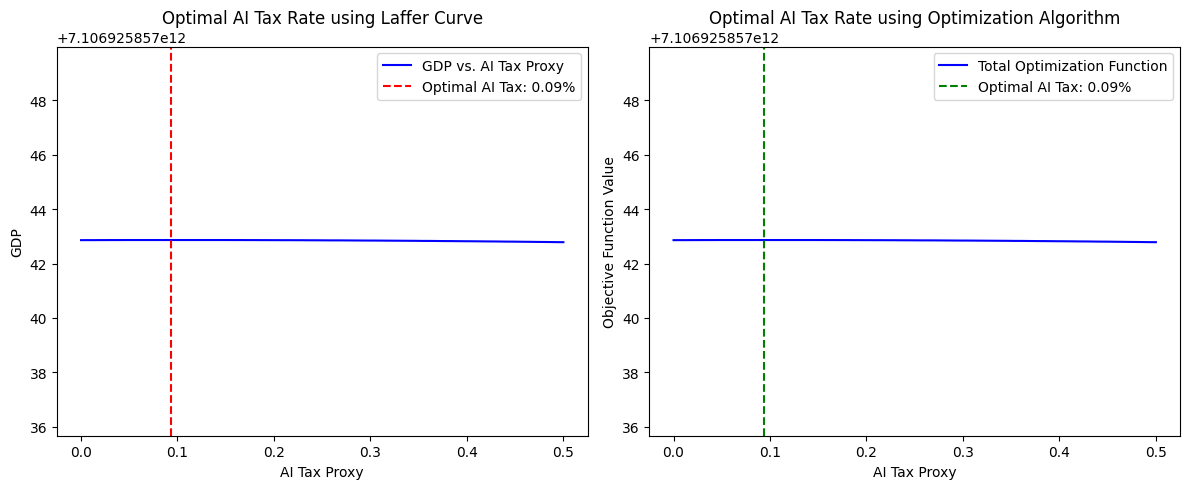

In [29]:
tax_range = np.linspace(0, 0.5, 100)
gdp_values = laffer_curve(tax_range, *params)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(tax_range, gdp_values, label="GDP vs. AI Tax Proxy", color='blue')
ax[0].axvline(optimal_tax, color='red', linestyle='--', label=f"Optimal AI Tax: {optimal_tax:.2f}%")
ax[0].set_title("Optimal AI Tax Rate using Laffer Curve")
ax[0].set_xlabel("AI Tax Proxy")
ax[0].set_ylabel("GDP")
ax[0].legend()

ax[1].plot(tax_range, gdp_values, label="Total Optimization Function", color='blue')
ax[1].axvline(optimal_tax, color='green', linestyle='--', label=f"Optimal AI Tax: {optimal_tax:.2f}%")
ax[1].set_title("Optimal AI Tax Rate using Optimization Algorithm")
ax[1].set_xlabel("AI Tax Proxy")
ax[1].set_ylabel("Objective Function Value")
ax[1].legend()

plt.tight_layout()
plt.show()

In [30]:
print(f"\n 최적 AI 세율 (Laffer Curve 결과): {optimal_tax:.2f}%")


 최적 AI 세율 (Laffer Curve 결과): 0.09%


## 연도, 국가 추가

### 동태적 특성과 국가별 최적 AI 세율 측정
- year 데이터를 독립변수에 포함 -> 시간적 변화 반영
- GDP ~ f(AI Tax Proxy, Year) 형태로 분석
- 국가별로 다른 최적 AI 세율이 도출되도록 최적화
- 연도별 최적 AI 세율 변화 추세(시각화)
- 국가별로 AI Tax Proxy와 GDP 간 관계 별도 분석

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, curve_fit, differential_evolution
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
np.random.seed(42)
correlation_threshold = 0.45

file_path = "../data/master_data_by_category_clear.csv"
df = pd.read_csv(file_path)

### 1. 국가별 개별 DataFrame 생성

In [33]:
China_df = df[df["Country"] == "China"].copy()
France_df = df[df["Country"] == "France"].copy()
USA_df = df[df["Country"] == "United States of America"].copy()
Germany_df = df[df["Country"] == "Germany"].copy()
Japan_df = df[df["Country"] == "Japan"].copy()
Korea_df = df[df["Country"] == "Korea"].copy()
UK_df = df[df["Country"] == "United Kingdom"].copy()

In [34]:
def get_high_corr_vars(country_df):
    country_numeric_df = country_df.select_dtypes(include=[np.number]).drop(["GDP", "Year"], axis=1, errors="ignore")
    correlations = country_numeric_df.corrwith(country_df["GDP"]).dropna().abs()
    return correlations[correlations > correlation_threshold].index.tolist()

# 각 국가별 상관관계 높은 변수 찾기
China_high_corr_vars = get_high_corr_vars(China_df)
France_high_corr_vars = get_high_corr_vars(France_df)
USA_high_corr_vars = get_high_corr_vars(USA_df)
Germany_high_corr_vars = get_high_corr_vars(Germany_df)
Japan_high_corr_vars = get_high_corr_vars(Japan_df)
Korea_high_corr_vars = get_high_corr_vars(Korea_df)
UK_high_corr_vars = get_high_corr_vars(UK_df)

# 국가별 변수 저장
China_df = China_df[["Country", "Year", "GDP"] + China_high_corr_vars]
France_df = France_df[["Country", "Year", "GDP"] + France_high_corr_vars]
USA_df = USA_df[["Country", "Year", "GDP"] + USA_high_corr_vars]
Germany_df = Germany_df[["Country", "Year", "GDP"] + Germany_high_corr_vars]
Japan_df = Japan_df[["Country", "Year", "GDP"] + Japan_high_corr_vars]
Korea_df = Korea_df[["Country", "Year", "GDP"] + Korea_high_corr_vars]
UK_df = UK_df[["Country", "Year", "GDP"] + UK_high_corr_vars]

c:\workspace\2025oss-couscous\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [35]:
print("\n 국가별 GDP와 높은 상관관계를 가진 변수:\n")
print(f"China: {China_high_corr_vars}")
print(f"France: {France_high_corr_vars}")
print(f"USA: {USA_high_corr_vars}")
print(f"Germany: {Germany_high_corr_vars}")
print(f"Japan: {Japan_high_corr_vars}")
print(f"Korea: {Korea_high_corr_vars}")
print(f"UK: {UK_high_corr_vars}")


 국가별 GDP와 높은 상관관계를 가진 변수:

China: ['Business sophistication', 'Creative outputs', 'GDP_per_capita_PPP', 'GERD', 'GNI_per_capita', 'Global Innovation Index', 'Human capital and research', 'Infrastructure', 'Institutions', 'Internet Usage', 'Market sophistication', 'Patent Publications', 'WIPO Tax']
France: ['GNI_per_capita', 'Human capital and research', 'Infrastructure', 'Internet Usage', 'Knowledge and technology outputs', 'Patent Publications']
USA: ['Business sophistication', 'Corporate Tax', 'GDP_per_capita_PPP', 'GERD', 'GNI_per_capita', 'Global Innovation Index', 'Internet Usage', 'Knowledge and technology outputs', 'Market sophistication', 'WIPO Tax']
Germany: ['Business sophistication', 'Creative outputs', 'GDP_per_capita_PPP', 'GERD', 'GNI_per_capita', 'General Revenue', 'Human capital and research', 'Internet Usage', 'Market sophistication', 'Unemployment Rate', 'WIPO Tax']
Japan: ['GERD', 'Institutions', 'Knowledge and technology outputs', 'Market sophistication']
Korea: ['

In [36]:
scaler = MinMaxScaler(feature_range=(0, 0.5))

def find_best_proxy(country_df, high_corr_vars):
    proxy_candidates = []
    
    for r in range(2, 4):
        for combo in combinations(high_corr_vars, r):
            valid_combo = [col for col in combo if col in country_df.columns]
            if len(valid_combo) == r:
                proxy_name = f"AI_Tax_Proxy_{'_'.join(valid_combo)}"
                df_scaled = scaler.fit_transform(country_df[valid_combo])
                country_df[proxy_name] = df_scaled.mean(axis=1)
                proxy_candidates.append(proxy_name)
    
    return proxy_candidates

China_proxy_candidates = find_best_proxy(China_df, China_high_corr_vars)
France_proxy_candidates = find_best_proxy(France_df, France_high_corr_vars)
USA_proxy_candidates = find_best_proxy(USA_df, USA_high_corr_vars)
Germany_proxy_candidates = find_best_proxy(Germany_df, Germany_high_corr_vars)
Japan_proxy_candidates = find_best_proxy(Japan_df, Japan_high_corr_vars)
Korea_proxy_candidates = find_best_proxy(Korea_df, Korea_high_corr_vars)
UK_proxy_candidates = find_best_proxy(UK_df, UK_high_corr_vars)

C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  country_df[proxy_name] = df_scaled.mean(axis=1)
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  country_df[proxy_name] = df_scaled.mean(axis=1)
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

## 국가별 최적 AI 세율 도출

### 국가별 최적 AI 세율

In [37]:
def find_best_model(country_df, proxy_candidates):
    best_degree = 1
    best_bic = np.inf
    best_proxy = None
    
    for proxy in proxy_candidates:
        X = country_df[[proxy]].values
        y = country_df["GDP"].values
        
        for d in range(2, 7):
            poly = PolynomialFeatures(degree=d)
            X_poly = poly.fit_transform(X)
            model = LinearRegression()
            model.fit(X_poly, y)
            y_pred = model.predict(X_poly)
            bic = len(y) * np.log(mean_squared_error(y, y_pred)) + d * np.log(len(y))
            
            if bic < best_bic:
                best_bic = bic
                best_degree = d
                best_proxy = proxy
    
    return best_degree, best_proxy

In [38]:
China_best_degree, China_best_proxy = find_best_model(China_df, China_proxy_candidates)
France_best_degree, France_best_proxy = find_best_model(France_df, France_proxy_candidates)
USA_best_degree, USA_best_proxy = find_best_model(USA_df, USA_proxy_candidates)
Germany_best_degree, Germany_best_proxy = find_best_model(Germany_df, Germany_proxy_candidates)
Japan_best_degree, Japan_best_proxy = find_best_model(Japan_df, Japan_proxy_candidates)
Korea_best_degree, Korea_best_proxy = find_best_model(Korea_df, Korea_proxy_candidates)
UK_best_degree, UK_best_proxy = find_best_model(UK_df, UK_proxy_candidates)

print(f"\n 최적 차수 및 Proxy\n")
print(f"China: {China_best_degree}, {China_best_proxy}")
print(f"France: {France_best_degree}, {France_best_proxy}")
print(f"USA: {USA_best_degree}, {USA_best_proxy}")
print(f"Germany: {Germany_best_degree}, {Germany_best_proxy}")
print(f"Japan: {Japan_best_degree}, {Japan_best_proxy}")
print(f"Korea: {Korea_best_degree}, {Korea_best_proxy}")
print(f"UK: {UK_best_degree}, {UK_best_proxy}")


 최적 차수 및 Proxy

China: 6, AI_Tax_Proxy_Business sophistication_GDP_per_capita_PPP_GERD
France: 2, AI_Tax_Proxy_GNI_per_capita_Internet Usage
USA: 6, AI_Tax_Proxy_GDP_per_capita_PPP_GERD_GNI_per_capita
Germany: 6, AI_Tax_Proxy_Business sophistication_GDP_per_capita_PPP_Internet Usage
Japan: 6, AI_Tax_Proxy_GERD_Institutions
Korea: 6, AI_Tax_Proxy_GERD_GNI_per_capita_WIPO Tax
UK: 5, AI_Tax_Proxy_Institutions_WIPO Tax


In [39]:
country_optimal_params = {}
country_optimal_taxes = {}

for country, country_df, best_degree, best_proxy in [
    ("China", China_df, China_best_degree, China_best_proxy),
    ("France", France_df, France_best_degree, France_best_proxy),
    ("USA", USA_df, USA_best_degree, USA_best_proxy),
    ("Germany", Germany_df, Germany_best_degree, Germany_best_proxy),
    ("Japan", Japan_df, Japan_best_degree, Japan_best_proxy),
    ("Korea", Korea_df, Korea_best_degree, Korea_best_proxy),
    ("UK", UK_df, UK_best_degree, UK_best_proxy),
]:
    X_proxy = country_df[[best_proxy]].values.flatten()
    y_gdp = country_df["GDP"].values

    if best_degree > 1:
        try:
            params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
            country_optimal_params[country] = params
        except RuntimeError:
            print(f"{country}: Curve Fitting 실패")
            continue
    else:
        params = [0, 0, y_gdp.mean()]
        country_optimal_params[country] = params

    def optimize_tax(tax_rate):
        return -laffer_curve(tax_rate, *params)

    bounds = [(0, 0.4)]
    opt_result = differential_evolution(optimize_tax, bounds, seed=42)
    optimal_tax = opt_result.x[0]

    country_optimal_taxes[country] = optimal_tax
    print(f"{country} 최적 AI 세율: {optimal_tax:.4f}")

China 최적 AI 세율: 0.0960
France 최적 AI 세율: 0.0960
USA 최적 AI 세율: 0.1149
Germany 최적 AI 세율: 0.0960
Japan 최적 AI 세율: 0.0960
Korea 최적 AI 세율: 0.0960
UK 최적 AI 세율: 0.0960


C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\2049280341.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\2049280341.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\2049280341.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\2049280341.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_17148\2049280341.py:18: OptimizeWarning: Covariance of the parameters co

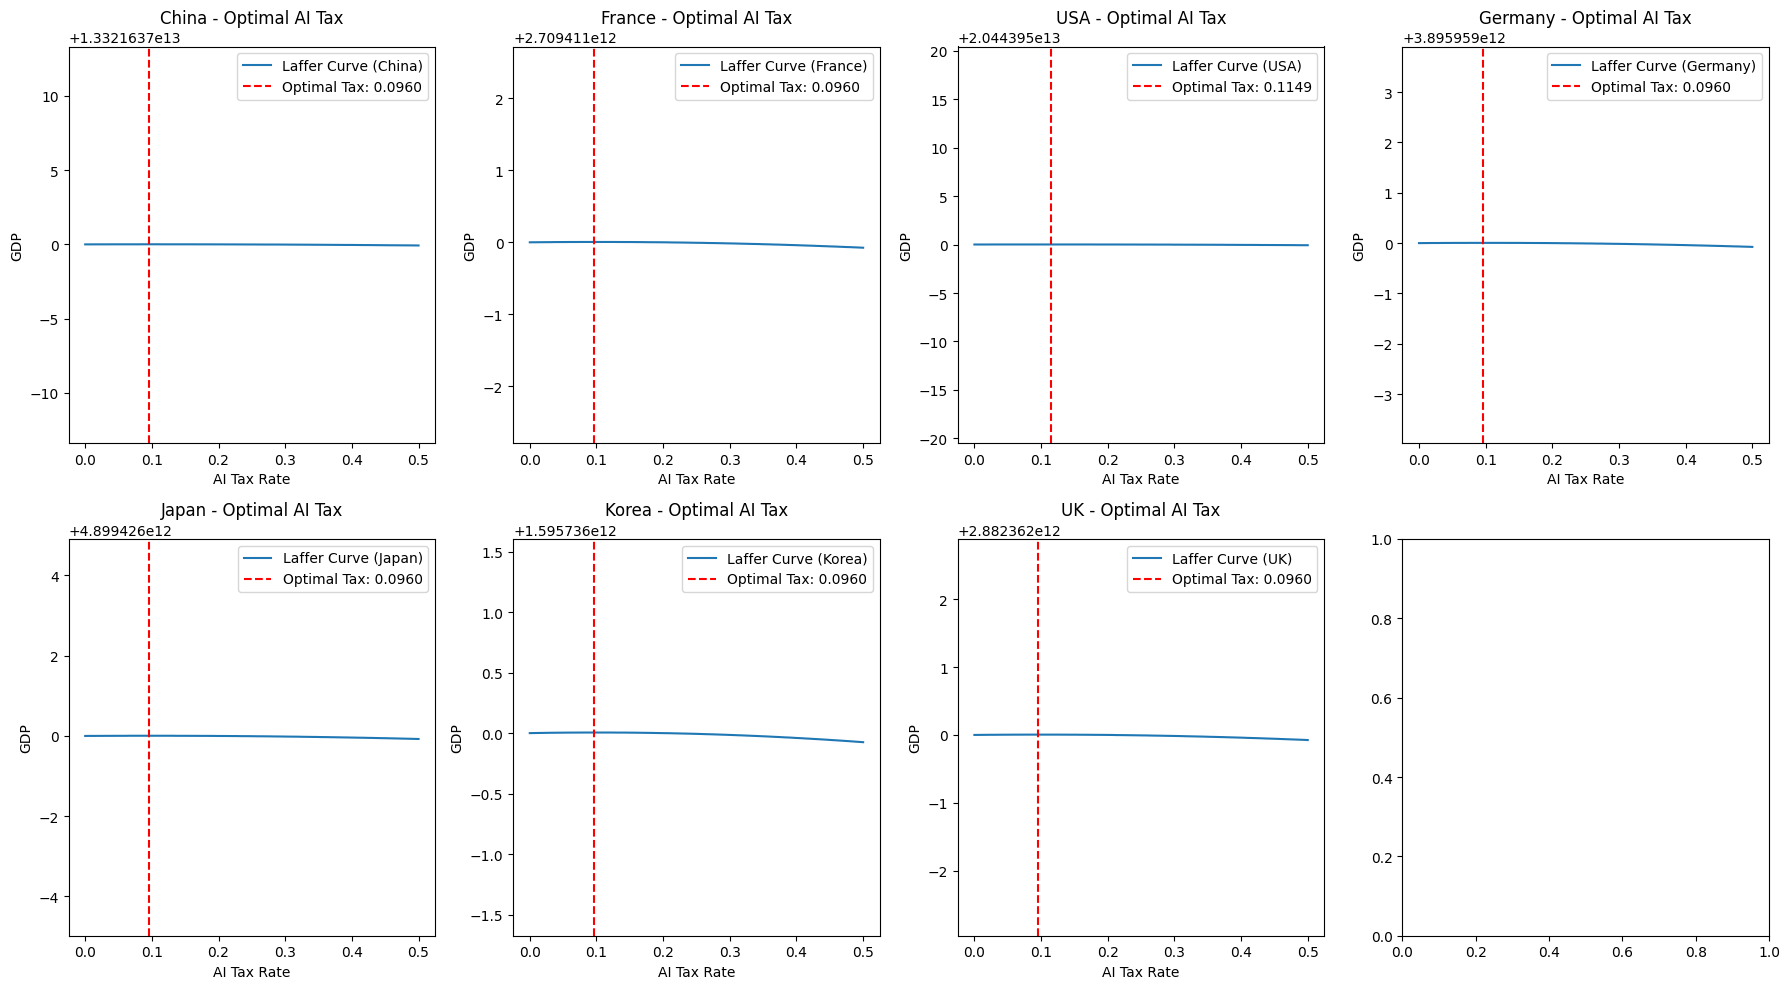

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, (country, params) in enumerate(country_optimal_params.items()):
    if country not in country_optimal_taxes:
        continue

    ax = axes[i]
    x_vals = np.linspace(0, 0.5, 100)
    y_vals = laffer_curve(x_vals, *params)

    ax.plot(x_vals, y_vals, label=f"Laffer Curve ({country})")
    ax.axvline(country_optimal_taxes[country], color="r", linestyle="--", label=f"Optimal Tax: {country_optimal_taxes[country]:.4f}")
    
    ax.set_title(f"{country} - Optimal AI Tax")
    ax.set_xlabel("AI Tax Rate")
    ax.set_ylabel("GDP")
    ax.legend()

plt.tight_layout()
plt.show()